# 구글 드라이브 마운트

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 데이터 불러오기

In [ ]:
import zipfile
import os

input_path = '/content/mask.zip' # 마스크 압축 파일 경로
output_dir = '/content/masks'

os.makedirs(output_dir, exist_ok=True)

with zipfile.ZipFile(input_path, 'r') as zip_ref:
    zip_ref.extractall(output_dir)

print(f"압축 해제 경로: {output_dir}")

img_dir = output_dir + '/'
file_names = [img_dir + file for file in os.listdir(img_dir) if os.path.isfile(os.path.join(img_dir, file))]
print(len(file_names))

압축 해제 경로: /content/masks
10


# 1. 좌하단의 좌표 구하기

In [ ]:
import math

## EPSG:5186 -> EPSG:4326

In [ ]:
from pyproj import Transformer

transformer = Transformer.from_crs("EPSG:5186", "EPSG:4326", always_xy=True)

x, y = 167420.630000005505281, 560847.391281746444292

lon, lat = transformer.transform(x, y)

print(f"변환된 좌표: {lat, lon}")

변환된 좌표: (37.64667441416647, 126.63083849106049)


## 테스트용 중심좌표 계산

In [ ]:
lat, lon = 37.64676257230551, 126.63084094416728
center_lat, center_lon = lat - (grid_lat / 2), lon + (grid_lon / 2)
print(center_lat, center_lon)

NameError: name 'grid_lat' is not defined

## 좌하단 좌표 계산

In [ ]:
center_lat, center_lon = 37.64441013987308, 126.63380821689455

In [ ]:
lat_radian = math.radians(center_lat)
grid_real = 0.51 * 1024
lat_dis = 111320
lon_dis = lat_dis * math.cos(lat_radian)
grid_lat = grid_real / lat_dis
grid_lon = grid_real / lon_dis

SW_lat, SW_lon = center_lat - (grid_lat / 2), center_lon - (grid_lon / 2)
print(f"좌하단 좌표: {SW_lat, SW_lon}")

좌하단 좌표: (37.642064469732944, 126.63084582573511)


# 2. 객체의 픽셀 추출

## (테스트용)

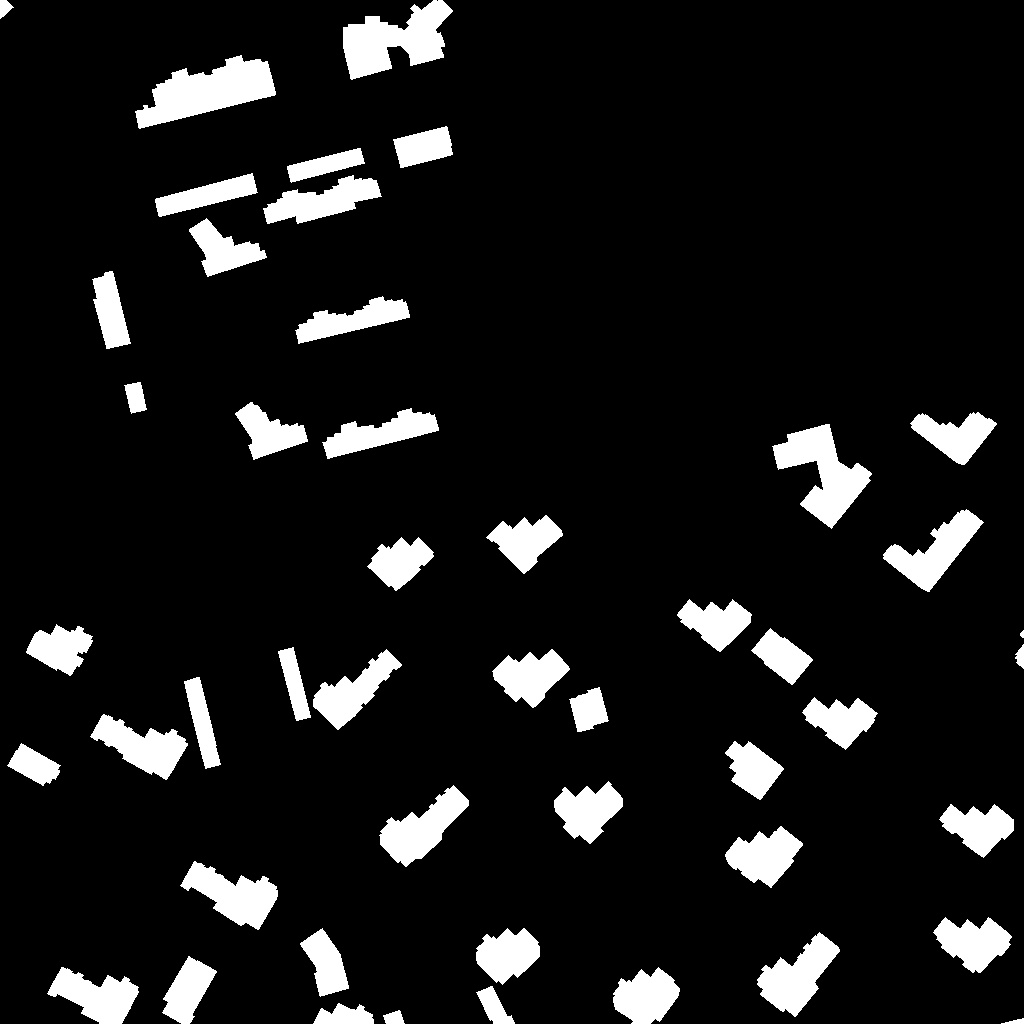

True

In [ ]:
import cv2
import numpy as np
from IPython.display import display, Image

filename = "/content/LC_AP_37607046_001_FGT_1024.tif"

img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)

result = np.where(img == 10, 255, 0).astype(np.uint8)

display(Image(data=cv2.imencode('.jpg', result)[1].tobytes()))

output_filename = "result.png"
cv2.imwrite(output_filename, result)

## 객체 선택

In [ ]:
import cv2
import numpy as np

filename = "result.png"

mask = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)

# 연결된 구성요소 분석
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask, connectivity=4)

print(f"총 객체 수: {num_labels - 1}") # 0은 배경

# for i in range(1, num_labels):
#     print(f"객체 {i}: 픽셀 개수 = {stats[i, cv2.CC_STAT_AREA]}, 중심 = {centroids[i]}")

selected_object = 1
print(f"객체 {selected_object}: 픽셀 개수 = {stats[selected_object, cv2.CC_STAT_AREA]}, 중심 = {centroids[selected_object]}")
# if selected_object >= num_labels or selected_object < 1:
#     raise ValueError(f"유효하지 않은 객체 번호입니다. 1 ~ {num_labels - 1} 사이에서 선택하세요.")

# # 마스크 생성
# selected_mask = (labels == selected_object).astype(np.uint8) * 255

# # # 픽셀 좌표 추출
# # selected_pixels = np.column_stack(np.where(selected_mask > 0))
# # print(f"선택한 객체의 픽셀 좌표:\n{selected_pixels}")

# # 선택한 객체 마스크 시각화
# cv2.imwrite("selected_object_mask.png", selected_mask)
# print("선택한 객체의 마스크를 'selected_object_mask.png'로 저장했습니다.")
cen_x = [coord[0] for coord in centroids[1:]]
cen_y = [coord[1] for coord in centroids[1:]]
print(f"({min(cen_x), min(cen_y)}, {max(cen_x), max(cen_y)})")

obj_point = (centroids[selected_object])

총 객체 수: 48
객체 1: 픽셀 개수 = 159, 중심 = [4.42138365 7.49685535]
((4.421383647798742, 7.49685534591195), (1021.8695652173913, 1021.4415584415584))


# 3. 객체 픽셀 - 좌하단 픽셀의 거리 계산

유클리드 거리 공식 사용

In [ ]:
import math

SW_point = (0, 1024)
dis = math.sqrt((obj_point[0] - SW_point[0])**2 + (obj_point[1] - SW_point[1])**2)
print(f"좌하단까지의 거리: {dis}")

좌하단까지의 거리: 1016.5127602371801


# 4. 픽셀 간 거리를 실제 거리로 환산

In [ ]:
real_dis = dis * 0.51
print(f"실제 거리: {real_dis}m")

실제 거리: 518.4215077209619m


# 5. Inverse-Haversine 공식 적용

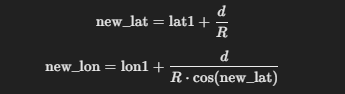

## 방위각 구하기

* 벡터의 내적과 각도 계산

$$ cos\theta = \frac{v_1 \cdot v_2}{\Vert v_1 \Vert \Vert v_2 \Vert}$$

> $$v_1 \cdot v_2 = (x_2 - x_1) \cdot (x_4 - x_3) + (y_2 - y_1) \cdot (y_4 - y_3)$$

> $$\Vert v_1 \Vert = \sqrt{(x_2 - x_1)^2 + (y_2 - y_1)^2}$$

> $$\Vert v_2 \Vert = \sqrt{(x_4 - x_3)^2 + (y_4 - y_3)^2}$$

In [ ]:
import math

def calculate_bearing(x1, y1, x2, y2, x3, y3, x4, y4):
    # 벡터 1: (x1, y1) -> (x2, y2)
    v1_x, v1_y = x2 - x1, y2 - y1
    # 벡터 2: (x3, y3) -> (x4, y4)
    v2_x, v2_y = x4 - x3, y4 - y3

    dot_product = v1_x * v2_x + v1_y * v2_y

    mag_v1 = math.sqrt(v1_x**2 + v1_y**2)
    mag_v2 = math.sqrt(v2_x**2 + v2_y**2)

    cos_theta = dot_product / (mag_v1 * mag_v2)
    cos_theta = max(-1.0, min(1.0, cos_theta))

    angle_radians = math.acos(cos_theta)
    angle_degrees = math.degrees(angle_radians)

    if angle_degrees > 90:
        angle_degrees = 180 - angle_degrees

    return angle_degrees

x1, y1 = 0, 1024
x2, y2 = 0, 0
x3, y3 = 0, 1024
x4, y4 = 4.42138365, 7.49685535

bearing = calculate_bearing(x1, y1, x2, y2, x3, y3, x4, y4)
print(f"방위각: {bearing:.2f}°")

방위각: 0.25°


haversine은 각도를 도 단위가 아닌 라디안으로 사용함
*수정 필요*

## 공식 적용

In [ ]:
import math

def reverse_haversine(lat, lon, distance, bearing):
    # 지구 반지름 (meters)
    R = 6371000

    lat_rad = math.radians(lat)
    lon_rad = math.radians(lon)
    bearing_rad = math.radians(bearing)

    new_lat_rad = math.asin(
        math.sin(lat_rad) * math.cos(distance / R) +
        math.cos(lat_rad) * math.sin(distance / R) * math.cos(bearing_rad)
    )

    new_lon_rad = lon_rad + math.atan2(
        math.sin(bearing_rad) * math.sin(distance / R) * math.cos(lat_rad),
        math.cos(distance / R) - math.sin(lat_rad) * math.sin(new_lat_rad)
    )

    new_lat = math.degrees(new_lat_rad)
    new_lon = math.degrees(new_lon_rad)

    return new_lat, new_lon

end_lat, end_lon = reverse_haversine(SW_lat, SW_lon, real_dis, bearing)
print(f"도착지 좌표: {end_lat, end_lon}")

도착지 좌표: (37.64672670225658, 126.63087143708164)


37.64667441416647, 126.63083849106049


# 6. 좌표로 주소 알아내기

모델이 탐지한 건물의 픽셀 지점을 보고 위/경도를 알아낸 뒤, 해당 좌표를 주소로 변환하는 과정 필요

## 테스트

In [ ]:
import geopandas as gpd
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent="South Korea")

data = {
    "latitude": [37.64673346454887],
    "longitude": [126.63084139693287]
}
gdf = gpd.GeoDataFrame(data)

def reverse_geocode(lat, lon):
    try:
        location = geolocator.reverse((lat, lon), timeout=10)
        return location.address if location else None
    except Exception as e:
        print(f"Error: {e}")
        return None

gdf["address"] = gdf.apply(lambda row: reverse_geocode(row["latitude"], row["longitude"]), axis=1)

gdf

,latitude,longitude,address
0,37.646733,126.630841,"미태리김포카림애비뉴점, 김포한강4로, 구래동, 양곡리, 김포시, 경기도, 10066..."


In [ ]:
url = 'https://maps.googleapis.com/maps/api/geocode/json?latlng=40.714224,-73.961452&key=YOUR_API_KEY'

In [ ]:
import requests

API_KEY = ''

lat = 37.64673346454887
lon = 126.63084139693287

url = f'https://maps.googleapis.com/maps/api/geocode/json?latlng={lat},{lon}&key={API_KEY}'

res = requests.get(url)
data = res.json()

if data['status'] == 'OK':
  print(data)
else:
  print("API 요청 실패")

{'plus_code': {'compound_code': 'JJWJ+M8W Gimpo-si, Gyeonggi-do, South Korea', 'global_code': '8Q98JJWJ+M8W'}, 'results': [{'address_components': [{'long_name': 'South Korea', 'short_name': 'KR', 'types': ['country', 'political']}, {'long_name': 'Gimpo-si', 'short_name': 'Gimpo-si', 'types': ['locality', 'political']}, {'long_name': '10066', 'short_name': '10066', 'types': ['postal_code']}], 'formatted_address': 'South Korea, Gimpo-si, 반도4차상가2층 2071호 김포한강4로 487 김포시 경기도 KR', 'geometry': {'location': {'lat': 37.6465448, 'lng': 126.6309663}, 'location_type': 'GEOMETRIC_CENTER', 'viewport': {'northeast': {'lat': 37.6478937802915, 'lng': 126.6323152802915}, 'southwest': {'lat': 37.6451958197085, 'lng': 126.6296173197085}}}, 'place_id': 'ChIJG8nbkJ-HfDURrYNk8zGiODk', 'plus_code': {'compound_code': 'JJWJ+J9 Gimpo-si, Gyeonggi-do, South Korea', 'global_code': '8Q98JJWJ+J9'}, 'types': ['dentist', 'establishment', 'health', 'point_of_interest']}, {'address_components': [{'long_name': '6928-1', '

In [ ]:
import json

In [ ]:
data['results'][0]['formatted_address']

'South Korea, Gimpo-si, 반도4차상가2층 2071호 김포한강4로 487 김포시 경기도 KR'

In [ ]:
pretty_json = json.dumps(data, indent = 4, ensure_ascii = False)
print(pretty_json)

{
    "plus_code": {
        "compound_code": "JJWJ+M8W Gimpo-si, Gyeonggi-do, South Korea",
        "global_code": "8Q98JJWJ+M8W"
    },
    "results": [
        {
            "address_components": [
                {
                    "long_name": "South Korea",
                    "short_name": "KR",
                    "types": [
                        "country",
                        "political"
                    ]
                },
                {
                    "long_name": "Gimpo-si",
                    "short_name": "Gimpo-si",
                    "types": [
                        "locality",
                        "political"
                    ]
                },
                {
                    "long_name": "10066",
                    "short_name": "10066",
                    "types": [
                        "postal_code"
                    ]
                }
            ],
            "formatted_address": "South Korea, Gimpo-si, 반도4차상가2층 2071

## 수집

In [ ]:
import pandas as pd

data = pd.read_csv('buildings.csv')
data

In [ ]:
API_KEY = ""

In [ ]:
import requests

def get_address_from_coords(x, y):
    url = "https://dapi.kakao.com/v2/local/geo/coord2address.json"
    headers = {"Authorization": f"KakaoAK {API_KEY}"}
    params = {"x": x, "y": y, "input_coord": "WGS84"}

    response = requests.get(url, headers = headers, params = params)

    if response.status_code == 200:
        result = response.json()
        documents = result.get("documents", [])

        if documents:
            address_info = documents[0].get("address", {})
            road_address_info = documents[0].get("road_address", {})

            return {"지번주소": address_info.get("address_name", ""),
                    "도로명주소": road_address_info["address_name"] if road_address_info else "",
                    '건물 이름': road_address_info["building_name"] if road_address_info else "",
                    '우편번호': road_address_info["zone_no"] if road_address_info else ""}
        else:
            return {"지번주소": "", "도로명주소": "", "건물 이름": "", "우편번호": ""}
    else:
        return {"error": f"API 요청 실패 (HTTP {response.status_code})"}

In [ ]:
import time
from tqdm import tqdm

road_address = list()
address = list()
building_name = list()
zone_no = list()

data1 = data[99000:]
data1_1 = data1[:17000]

for idx, row in tqdm(data1.iterrows(), total=len(data1)):
  try:
    x = row['lon']
    y = row['lat']

    res = get_address_from_coords(x, y)

    road_address.append(res.get('도로명주소', ""))
    address.append(res.get('지번주소', ""))
    building_name.append(res.get('건물 이름', ""))
    zone_no.append(res.get('우편번호', ""))
    time.sleep(0.1)

  except Exception:
    print(Exception)
    road_address.append("")
    address.append("")
    building_name.append("")
    zone_no.append("")

data1['road_address'] = road_address
data1['address'] = address
data1['building_name'] = building_name
data1['zone_no'] = zone_no

data1

In [ ]:
data1.to_csv('building_address(99000-).csv')